#### Import packages and device selection

In [1]:
import gc
import os
import re
import cv2
from tqdm.notebook import tqdm
import optuna
from optuna.trial import TrialState
import torch
from torch import nn, optim
from torch.utils.checkpoint import checkpoint
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchmetrics.functional.image import structural_similarity_index_measure
from torchvision import transforms
from torchinfo import summary
from sklearn.model_selection import KFold, train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [2]:
SIZE = 224
seed = 42
device = 'cuda' if torch.cuda.is_available() else 'cpu'
np.random.seed(seed)
torch.manual_seed(seed) # if using CPU
torch.cuda.manual_seed(seed) # if using single-GPU
torch.cuda.manual_seed_all(seed) # if using multi-GPU
torch.backends.cudnn.deterministic = True # deterministic mode
torch.backends.cudnn.benchmark = False # disable auto-tuner to find the best algorithm to use for your hardware
torch.backends.cuda.matmul.allow_tf32 = True # allow TensorFloat-32 on matmul operations
torch.backends.cudnn.allow_tf32  = True # allow TensorFloat-32 on convolution operations

In [3]:
print("Using device: ", device)

Using device:  cuda


## Dataset Loading and Preprocessing

#### This is used only to visualize some samples from the dataset

In [4]:
def sort_files(folder):
    convert_func = lambda x: int(x) if x.isdigit() else x.lower()
    key_func = lambda x: [convert_func(c) for c in re.split('([0-9]+)', x)]
    return sorted(folder, key=key_func)

input_L = []
target_ab = []
path = '../data/color'
folder = os.listdir(path)
folder = sort_files(folder)
for file in tqdm(folder, desc='Loading color images'):
    img = cv2.imread(os.path.join(path, file), 1)
    img = img.astype(np.float32) / 255.0 # [0..1]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    img = cv2.resize(img, (SIZE, SIZE))
    L = img[:, :, 0:1] # (H, W, 1) [0..100]
    ab = img[:, :, 1:3] # (H, W, 2) [-128..127]
    input_L.append(L)
    target_ab.append(ab)
input_L = np.array(input_L) # (N, H, W, 1)
target_ab = np.array(target_ab) # (N, H, W, 2

# def sort_files(folder):
#     convert_func = lambda x: int(x) if x.isdigit() else x.lower()
#     key_func = lambda x: [convert_func(c) for c in re.split('([0-9]+)', x)]
#     return sorted(folder, key=key_func)
#
# input_L = []
# target_ab = []
# path = '../data/color'
# folder = os.listdir(path)
# folder = sort_files(folder)

Loading color images:   0%|          | 0/7129 [00:00<?, ?it/s]

(7129, 224, 224, 1) (7129, 224, 224, 2)


In [5]:
print(input_L.shape, target_ab.shape)

(7129, 224, 224, 1) (7129, 224, 224, 2)


#### Display some samples

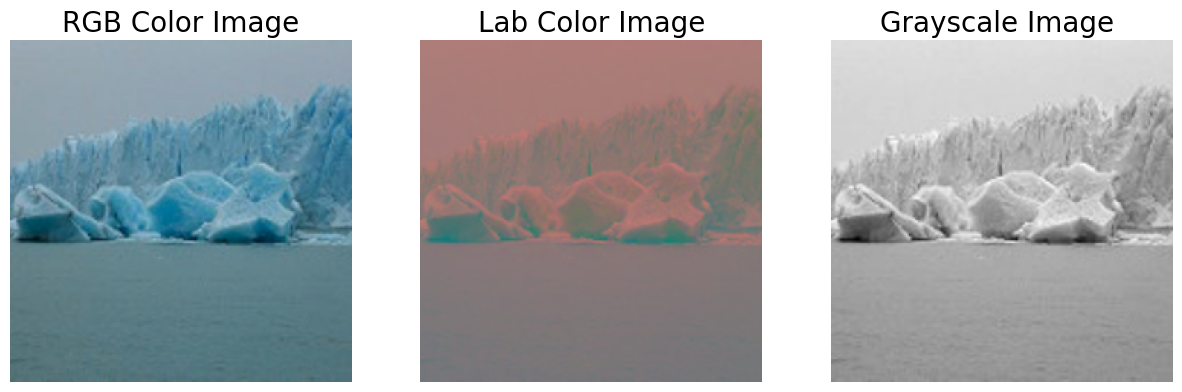

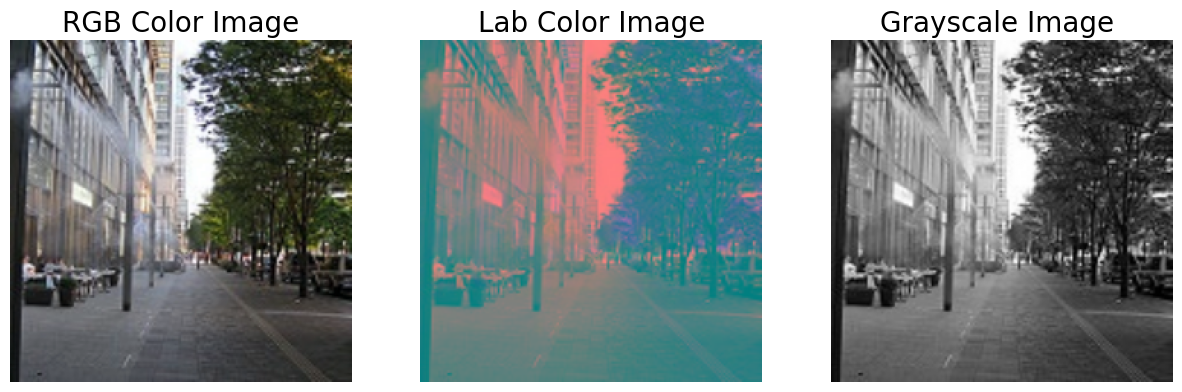

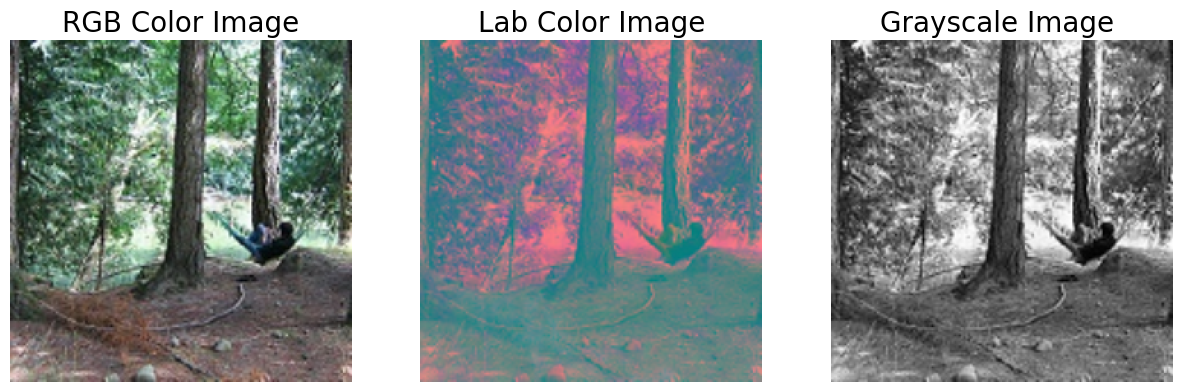

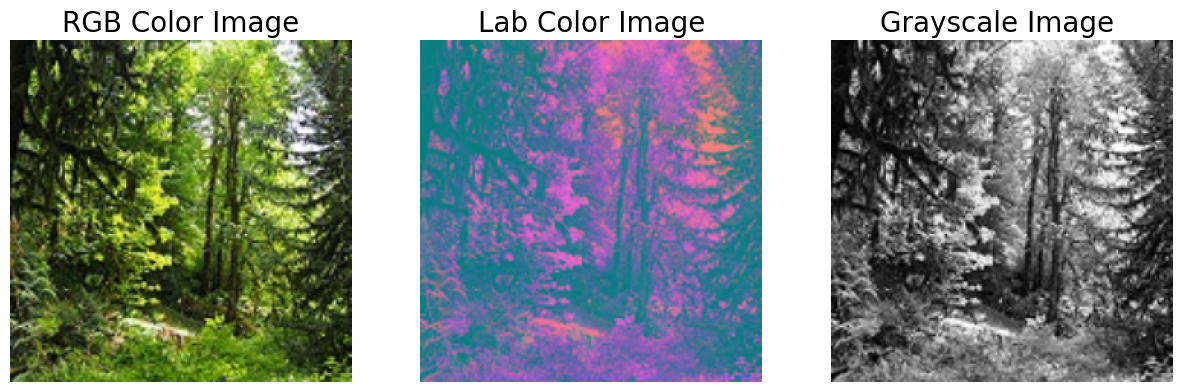

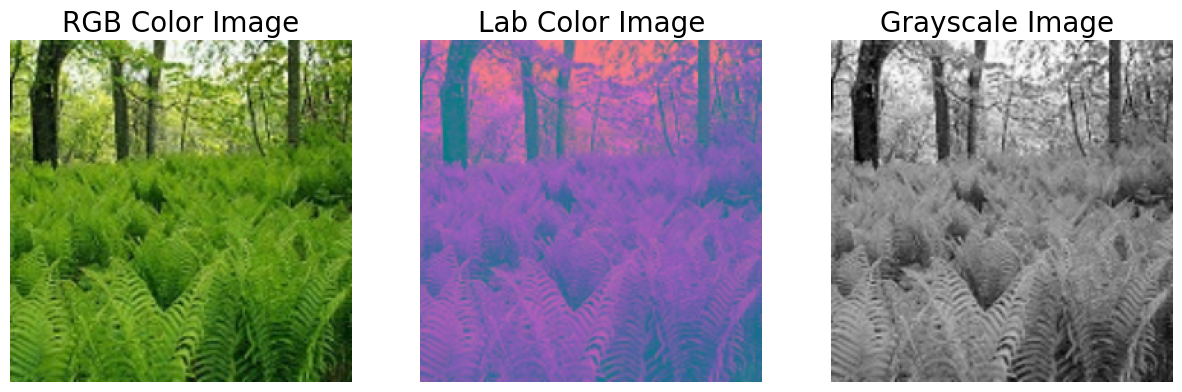

In [14]:
for _ in range(5):
    idx = np.random.randint(0, len(input_L) - 1)
    color_img = np.concatenate([input_L[idx] / 100 * 255, target_ab[idx] + 128], axis=2).clip(0, 255).astype(np.uint8)
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.title('RGB Color Image', fontsize=20)
    plt.imshow(np.clip(cv2.cvtColor(color_img, cv2.COLOR_LAB2RGB), 0, 255))
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title('Lab Color Image', fontsize=20)
    plt.imshow(color_img)
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title('Grayscale Image ', fontsize=20)
    plt.imshow((input_L[idx] / 100 * 255).astype(np.uint8).squeeze(), cmap='gray')
    plt.axis('off')
    plt.show()

#### Split into training and test data

In [ ]:
# del input_L, target_ab
# all_filepaths = np.array([os.path.join(path, file) for file in folder])
# train_data, test_data = train_test_split(all_filepaths, test_size=0.3, random_state=seed)
# val_data, test_data = train_test_split(test_data, test_size=0.3, random_state=seed)

In [ ]:
# print(train_data.shape, val_data.shape, test_data.shape)

We can use the entire dataset, instead of the file path, as it is small enough to fit in memory

In [ ]:
input_L = (torch.from_numpy(input_L) / 100.0).permute(0, 3, 1, 2) # (N, 1, H, W) [0..1]
target_ab = torch.from_numpy(target_ab).permute(0, 3, 1, 2) # (N, 2, H, W) [-128..127]
L_train, L_test, ab_train, ab_test = train_test_split(input_L, target_ab, test_size=0.2, random_state=seed)
L_val, L_test, ab_val, ab_test = train_test_split(L_test, ab_test, test_size=0.2, random_state=seed)

In [ ]:
print(L_train.shape, ab_train.shape)
print(L_val.shape, ab_val.shape)
print(L_test.shape, ab_test.shape)

In [ ]:
L_mean = torch.mean(L_train, dim=[0, 2, 3])
L_std = torch.std(L_train, dim=[0, 2, 3])

In [ ]:
print(L_mean, L_std)

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, L_data, ab_data, L_transform=None):
        self.L_data = L_transform(L_data) if L_transform else L_data
        self.ab_data = ab_data

    def __len__(self):
        return len(self.L_data)

    def __getitem__(self, idx):
        return self.L_data[idx], self.ab_data[idx]

# class MyDataset(torch.utils.data.Dataset):
#     def __init__(self, filepaths, lut, L_transform=None):
#         self.filepaths = filepaths
#         self.lut = lut.cpu()
#         self.L_transform = L_transform
#
#     def __len__(self):
#         return len(self.filepaths)
#
#     def __getitem__(self, idx):
#         img_path = self.filepaths[idx]
#         img = cv2.imread(img_path, 1)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
#         img = cv2.resize(img, (SIZE, SIZE))
#         L = (img[:, :, 0:1].astype(np.float32) / 255.0).transpose(2, 0, 1) # (1, H, W) [0..1]
#         ab = (img[:, :, 1:3].astype(np.uint8)).transpose(2, 0, 1) # (2, H, W) [0..255]
#         L_data = torch.from_numpy(L)
#         ab_data = torch.from_numpy(ab).long()
#         if self.L_transform:
#             L_data = self.L_transform(L_data)
#         with torch.no_grad():
#             a = ab_data[0, :, :]
#             b = ab_data[1, :, :]
#             idx = a * 256 + b
#             label = self.lut[idx]
#         return L_data, label

In [ ]:
class CUDAPrefetcher:
    def __init__(self, loader):
        self.loader = iter(loader)
        self.stream = torch.cuda.Stream()
        self.next_L = None
        self.next_ab = None
        self._preload()

    def _preload(self):
        try:
            self.next_L, self.next_ab = next(self.loader)
        except StopIteration:
            self.next_L = None
            return
        with torch.cuda.stream(self.stream):
            self.next_L = self.next_L.to(device, memory_format=torch.channels_last, non_blocking=True)
            self.next_ab = self.next_ab.to(device, non_blocking=True)

    def next(self):
        torch.cuda.current_stream().wait_stream(self.stream)
        L, ab = self.next_L, self.next_ab
        self._preload()
        return L, ab

# class CUDAPrefetcher:
#     def __init__(self, loader):
#         self.loader = iter(loader)
#         self.stream = torch.cuda.Stream()
#         self.next_L = None
#         self.next_labels = None
#         self._preload()
#
#     def _preload(self):
#         try:
#             self.next_L, self.next_labels = next(self.loader)
#         except StopIteration:
#             self.next_L = None
#             return
#         with torch.cuda.stream(self.stream):
#             self.next_L = self.next_L.to(device, memory_format=torch.channels_last, non_blocking=True)
#             self.next_labels = self.next_labels.to(device, non_blocking=True)
#
#     def next(self):
#         torch.cuda.current_stream().wait_stream(self.stream)
#         L, labels = self.next_L, self.next_labels
#         self._preload()
#         return L, labels

In [ ]:
# cluster_path = '../data/pts_in_hull.npy'
# assert os.path.exists(cluster_path), "Download pts_in_hull.npy and place next to this script"
# cluster_centers = torch.from_numpy(np.load(cluster_path)).float() # (313, 2) [-128..127]
# cc_l2 = (cluster_centers ** 2).sum(dim=1) # (313,)
# lut_coords  = (((torch.stack(torch.meshgrid(torch.arange(256), torch.arange(256), indexing='xy'), dim=-1).float()) - 128.0)
#                .reshape(-1, 2)) # (65536, 2) [-128..127]
#
# def compute_dist(tensor):
#     dists = ((tensor ** 2).sum(dim=1, keepdim=True) # (B*H*W, 1)
#              + cc_l2.reshape(1, -1) # (1, 313)
#              - 2 * torch.matmul(tensor, cluster_centers.t())) # (B*H*W, 313)
#     return dists
#
# dists = compute_dist(lut_coords)
# del lut_coords
# # lut = torch.argmin(dists, dim=1).long() # (65536,) [0..312] LUT for mapping (a, b) to cluster index
# soft_lut_probs = torch.softmax(-dists, dim=1)  # shape: (65536, 313)
# lut = torch.argmax(soft_lut_probs, dim=1).long()  # shape: (65536,)
# del dists

In [ ]:
# temp_dataset = MyDataset(train_data, lut)
# temp_loader = DataLoader(temp_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True, prefetch_factor=2)
# L_pixel_count, L_sum, L_sum_sq = 0, 0.0, 0.0
# ab_pixel_count, ab_sum, ab_sum_sq = 0, 0.0, 0.0
# for l, ab in tqdm(temp_loader, desc='Computing L and ab channel mean and std'):
#     l = l.float()
#     ab = ab.float()
#     L_sum += torch.sum(l)
#     L_sum_sq += torch.sum(l ** 2)
#     L_pixel_count += l.numel()
#     ab_sum += torch.sum(ab)
#     ab_sum_sq += torch.sum(ab ** 2)
#     ab_pixel_count += ab.numel()
# L_mean = (L_sum / L_pixel_count).item()
# L_std = torch.sqrt((L_sum_sq / L_pixel_count) - (L_mean ** 2)).item()
# ab_mean = (ab_sum / ab_pixel_count).item()
# ab_std = torch.sqrt((ab_sum_sq / ab_pixel_count) - (ab_mean ** 2)).item()
# del temp_dataset, temp_loader, l, ab, L_sum, L_sum_sq, L_pixel_count, ab_sum, ab_sum_sq, ab_pixel_count

In [ ]:
# print(L_mean, L_std)
# print(ab_mean, ab_std)

In [ ]:
trainset = MyDataset(L_train, ab_train, L_transform=transforms.Normalize(mean=L_mean, std=L_std))
valset = MyDataset(L_val, ab_val, L_transform=transforms.Normalize(mean=L_mean, std=L_std))
testset = MyDataset(L_test, ab_test, L_transform=transforms.Normalize(mean=L_mean, std=L_std))
del L_train, ab_train, L_val, ab_val, L_test, ab_test

## Training pipeline

#### Early stopping used to stop training if model begins to overfit

In [ ]:
def save_checkpoint(model, name='checkpoint'):
    torch.save(model.state_dict(), f"../models/{name}.pth")

class EarlyStopping:
    def __init__(self, patience=10, delta=0.05):
        self.patience = patience
        self.counter = 0
        self.best_score = np.Inf
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss, net):
        if self.best_score > val_loss:
            self.best_score = val_loss
            self.counter = 0
            save_checkpoint(net)
        elif self.best_score + self.delta < val_loss:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [ ]:
def compute_pcc_components(pred, targets):
    pred_flat = pred.reshape(pred.size(0), -1)
    target_flat = targets.reshape(targets.size(0), -1)
    vx = pred_flat - pred_flat.mean(dim=1, keepdim=True)
    vy = target_flat - target_flat.mean(dim=1, keepdim=True)
    numerator = (vx * vy).sum(dim=1) # covariance
    denominator1 = (vx ** 2).sum(dim=1)
    denominator2 = (vy ** 2).sum(dim=1)
    return numerator, denominator1, denominator2

def fit(net, trainloader, optimizer, scaler, loss_fn, beta=0.5):
    net.train()
    total_loss, total_sse, total_psnr, total_ssim, total_pcc_num, total_pcc_den1, total_pcc_den2, pixels, count = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0
    prefetcher = CUDAPrefetcher(trainloader)
    inputs, targets = prefetcher.next()
    while inputs is not None:
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast():
            out, mu, logvar = net(inputs)
            out = (out + 1) / 2 * 255 - 128  # rescale to [-128, 127]
            loss_rec = loss_fn(out, targets)
            loss_kld = -0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim=1).mean()
            loss = loss_rec + beta * loss_kld
        scaler.scale(loss).backward()
        nn.utils.clip_grad_norm_(net.parameters(), 3)
        scaler.step(optimizer)
        scaler.update()
        with torch.no_grad():
            total_loss += loss_rec.item()
            count += 1
            sse = nn.MSELoss(reduction='sum')(out, targets)
            pixels += targets.numel()
            pcc_num, pcc_den1, pcc_den2 = compute_pcc_components(out, targets)
            total_sse += sse.item()
            total_ssim = structural_similarity_index_measure(out, targets).item()
            total_pcc_num += pcc_num.sum().item()
            total_pcc_den1 += pcc_den1.sum().item()
            total_pcc_den2 += pcc_den2.sum().item()
        inputs, targets = prefetcher.next()
    avg_mse = total_sse / pixels
    avg_rmse = avg_mse ** 0.5
    return (total_loss / count, avg_rmse, 20 * np.log10(1.0 / avg_rmse), total_ssim / count,
            (total_pcc_num / (total_pcc_den1 * total_pcc_den2) ** 0.5))

@torch.inference_mode()
def predict(net, valloader, loss_fn):
    net.eval()
    total_loss, total_sse, total_psnr, total_ssim, total_pcc_num, total_pcc_den1, total_pcc_den2, pixels, count = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0
    prefetcher = CUDAPrefetcher(valloader)
    inputs, targets = prefetcher.next()
    while inputs is not None:
        with torch.cuda.amp.autocast():
            out, mu, logvar = net(inputs)
            out = (out + 1) / 2 * 255 - 128  # rescale to [-128, 127]
            loss_rec = loss_fn(out, targets)
        total_loss += loss_rec.item()
        count += 1
        sse = nn.MSELoss(reduction='sum')(out, targets)
        pixels += targets.numel()
        pcc_num, pcc_den1, pcc_den2 = compute_pcc_components(out, targets)
        total_sse += sse.item()
        total_ssim = structural_similarity_index_measure(out, targets).item()
        total_pcc_num += pcc_num.sum().item()
        total_pcc_den1 += pcc_den1.sum().item()
        total_pcc_den2 += pcc_den2.sum().item()
        inputs, targets = prefetcher.next()
    avg_mse = total_sse / pixels
    avg_rmse = avg_mse ** 0.5
    return (total_loss / count, avg_rmse, 20 * np.log10(1.0 / avg_rmse), total_ssim / count,
            (total_pcc_num / (total_pcc_den1 * total_pcc_den2) ** 0.5))

#### Objective method for k fold cross validation

In [ ]:
def objective(trial, trainset, scaler, X):
    num_cycles = trial.suggest_int('num_cycles', 4, 10)
    cycle_length = num_epochs // num_cycles
    final_beta = 0.5
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    latent_dim = trial.suggest_categorical('latent_dim', [64, 128, 256, 512])
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    val_losses, mean_loss = [], 0.0
    split_n = 0
    prog_bar = tqdm(kf.split(X), desc="Splits", position=0)
    for train_idx, val_idx in prog_bar:
        split_n += 1
        trainloader = DataLoader(trainset, batch_size=batch_size, sampler=SubsetRandomSampler(train_idx), num_workers=4, pin_memory=True, prefetch_factor=2)
        valloader = DataLoader(trainset, batch_size=batch_size, sampler=SubsetRandomSampler(val_idx), num_workers=4, pin_memory=True, prefetch_factor=2)
        criterion = nn.MSELoss(reduction='mean').to(device, memory_format=torch.channels_last)
        # prior = compute_ab_prior(trainloader)
        # weights = make_rebalancing_weights(prior, alpha=0.5)
        # criterion = nn.CrossEntropyLoss(weight=weights, reduction='mean').to(device, memory_format=torch.channels_last)
        net = Net(latent_dim).to(device, memory_format=torch.channels_last)
        optimizer = optim.AdamW(net.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
        for epoch in range(50):
            cycle_pos = epoch % cycle_length
            beta = final_beta * (0.5 * (1 + np.cos(np.pi * (1 - cycle_pos / cycle_length))))
            train_loss, train_rmse, train_psnr, train_ssim, train_pcc = fit(net, trainloader, optimizer, scaler, criterion, beta)
            val_loss, val_rmse, val_psnr, val_ssim, val_pcc = predict(net, valloader, criterion)
            val_losses.append(val_loss)
            scheduler.step(val_loss)
            prog_bar.set_description(f"Epoch {epoch + 1}, lr={current_lr}, beta={beta:.3f}, Loss={train_loss:.3f}/{val_loss:.3f} | "
                                     f"Metrics train/val: RMSE={train_rmse:.3f}/{val_rmse:.3f}, PSNR={train_psnr:.3f}/{val_psnr:.3f}, "
                                     f"SSIM={train_ssim:.3f}/{val_ssim:.3f}, PCC={train_pcc:.3f}/{val_pcc:.3f}")
        del net, optimizer, scheduler
        mean_loss = np.mean(val_losses)
        trial.report(mean_loss, split_n)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    return mean_loss

#### CAE NN definition

out = (in - kernel + 2 * pad) / stride + 1

In [ ]:
class Net(nn.Module):
    def __init__(self, latent_dim=256):
        super(Net, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU()
        )
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc_mu_logvar = nn.Conv2d(256, 2 * latent_dim, kernel_size=1)
        # self.fc_mu = nn.Linear(256 * 28 * 28, latent_dim) # 28 is the dimension of the feature map
        # self.fc_logvar = nn.Linear(256 * 28 * 28, latent_dim)
        self.decoder_input = nn.Linear(latent_dim, 256 * 28 * 28)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (256, 28, 28)),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(16, 2, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        encoded = self.encoder(x) # [B, 256, 28, 28]
        pooled = self.pool(encoded) # [B, 256, 1, 1]
        mu_logvar = self.fc_mu_logvar(pooled).squeeze(-1).squeeze(-1) # [B, 2 * latent_dim]
        mu, logvar = mu_logvar.chunk(2, dim=1)
        # mu = self.fc_mu(encoded)
        # logvar = self.fc_logvar(encoded)
        z = self.reparameterize(mu, logvar)
        decoder_input = self.decoder_input(z)
        x = self.decoder(decoder_input)
        return x, mu, logvar

In [ ]:
writer = SummaryWriter('../runs')
net = Net().eval()
# torch.quantization.fuse_modules(net, [
#     ['conv3', 'bnorm1'],
#     ['conv4', 'bnorm2'],
#     ['conv5', 'bnorm3']
# ], inplace=True)
net = net.to(device, memory_format=torch.channels_last)
for m in net.modules():
    if isinstance(m, (torch.nn.Conv2d, torch.nn.ConvTranspose2d)):
        m.weight = torch.nn.Parameter(m.weight.to(memory_format=torch.channels_last))
dummy = torch.zeros(1, 1, SIZE, SIZE).to(device, memory_format=torch.channels_last)
writer.add_graph(net, dummy)
writer.flush()
summary(net, input_data=dummy, col_names=('input_size', 'output_size', 'num_params', 'trainable'))

Run command:\
tensorboard --logdir=runs\
Visible at http://localhost:6006/

#### Hyper parameter tuning

In [ ]:
# del dummy
# gc.collect()
# torch.cuda.empty_cache()
# X = np.zeros(len(trainset))
# torch.cuda.empty_cache()
# scaler = torch.cuda.amp.GradScaler()
# study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())
# study.optimize(lambda trial: objective(trial, trainset, scaler, X), n_trials=5)

In [ ]:
# pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
# complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
#
# print("Study statistics: ")
# print("  Number of finished trials: ", len(study.trials))
# print("  Number of pruned trials: ", len(pruned_trials))
# print("  Number of complete trials: ", len(complete_trials))
#
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))

#### Entire dataset

In [ ]:
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True, prefetch_factor=2)
valloader = DataLoader(valset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True, prefetch_factor=2)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True, prefetch_factor=2)
optimizer = optim.AdamW(net.parameters(), lr=1e-3, fused=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
criterion = nn.MSELoss(reduction='mean').to(device, memory_format=torch.channels_last)
# prior = compute_ab_prior(trainloader).to(device)
# weights = make_rebalancing_weights(prior, alpha=0.5)
# criterion = nn.CrossEntropyLoss(weight=weights, reduction='mean').to(device, memory_format=torch.channels_last)
del dummy # , prior

In [ ]:
gc.collect()
torch.cuda.empty_cache()

Only for testing botttlenecks

In [ ]:
# import torch.autograd.profiler as prof
#
# scaler = torch.cuda.amp.GradScaler()
# with prof.profile(record_shapes=True, use_cuda=True) as p:
#     with prof.record_function("train_step"):
#         _, *_ = fit(net, trainloader, optimizer, scaler, criterion)
# print(p.key_averages().table(sort_by="cuda_time_total", row_limit=10))

In [ ]:
%matplotlib notebook
def update_plot():
    line1.set_data(range(len(train_losses)), train_losses)
    line2.set_data(range(len(val_losses)), val_losses)
    ax.relim()
    ax.autoscale_view()
    fig.canvas.draw()

In [ ]:
early_stopping = EarlyStopping()
train_losses, train_rmses, train_psnrs, train_ssims, train_pccs = [], [], [], [], []
val_losses, val_rmses, val_psnrs, val_ssims, val_pccs = [], [], [], [], []
last_checkpoint = None
num_epochs = 50
num_cycles = 4
cycle_length = num_epochs // num_cycles
final_beta = 0.5
prog_bar = tqdm(range(num_epochs), total=num_epochs, desc='Training', position=0)

fig, ax = plt.subplots()
line1, = ax.plot([], [], label='Train Loss')
line2, = ax.plot([], [], label='Val Loss')
ax.legend()

scaler = torch.cuda.amp.GradScaler()
for epoch in prog_bar:
    cycle_pos = epoch % cycle_length
    beta = final_beta * (0.5 * (1 + np.cos(np.pi * (1 - cycle_pos / cycle_length))))
    train_loss, train_rmse, train_psnr, train_ssim, train_pcc = fit(net, trainloader, optimizer, scaler, criterion, beta)
    train_losses.append(train_loss)
    train_rmses.append(train_rmse)
    train_psnrs.append(train_psnr)
    train_ssims.append(train_ssim)
    train_pccs.append(train_pcc)
    val_loss, val_rmse, val_psnr, val_ssim, val_pcc = predict(net, valloader, criterion)
    val_losses.append(val_loss)
    val_rmses.append(val_rmse)
    val_psnrs.append(val_psnr)
    val_ssims.append(val_ssim)
    val_pccs.append(val_pcc)
    #scheduler.step(val_img_acc)
    #early_stopping(val_loss, net)
    current_lr = optimizer.param_groups[0]['lr']
    prog_bar.set_description(f"Epoch {epoch + 1}, lr={current_lr}, beta={beta:.3f}, Loss={train_loss:.3f}/{val_loss:.3f} | "
                             f"Metrics train/val: RMSE={train_rmse:.3f}/{val_rmse:.3f}, PSNR={train_psnr:.3f}/{val_psnr:.3f}, "
                             f"SSIM={train_ssim:.3f}/{val_ssim:.3f}, PCC={train_pcc:.3f}/{val_pcc:.3f}")
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)
    update_plot()
    # if early_stopping.early_stop:
    #     print("Early stopping")
    #     break
save_checkpoint(net, 'lastcheck')
writer.flush()

In [ ]:
%matplotlib inline
class ModelWithLoss(nn.Module):
    def __init__(self, net, loss_fn):
        super().__init__()
        self.net = net
        self.loss_fn = loss_fn

    def forward(self, x, y):
        preds = self.net(x)
        return self.loss_fn(preds, y)

## Evaluate results

To use NN:
rt = torch.jit.load("model_and_loss.pt")\
rt.eval()\
out = rt(input_tensor, target_tensor)

In [ ]:
@torch.inference_mode()
def final_predict(net, valloader):
    net.eval()
    ins, preds, truths = [], [], []
    prefetcher = CUDAPrefetcher(valloader)
    inputs, targets = prefetcher.next()
    prog_bar = tqdm(total=len(valloader), desc='Final Predicting', leave=False)
    while inputs is not None:
        with torch.cuda.amp.autocast():
            out, *_ = net(inputs)
            out = (out + 1) / 2 * 255 - 128  # rescale to [-128, 127]
        ins.append(inputs.cpu())
        preds.append(out.cpu())
        truths.append(targets.cpu())
        # ab_pred_soft = torch.einsum('bchw,cd->bdhw', torch.softmax(out.float(), dim=1), cluster_centers)
        # preds_soft.append(ab_pred_soft.cpu())
        # ab_pred_hard = cluster_centers[out.argmax(1)].permute(0, 3, 1, 2)
        # preds_hard.append(ab_pred_hard.cpu())
        # truths.append((cluster_centers[targets] + 128).permute(0, 3, 1, 2).cpu())
        inputs, targets = prefetcher.next()
        prog_bar.update(1)
    prog_bar.close()
    return ins, preds, truths

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# net.load_state_dict(torch.load('../models/checkpoint.pth'))
ins, preds, truths = final_predict(net, testloader)
# net_script = ModelWithLoss(net, nn.MSELoss(reduction='mean'))
# # net_script = ModelWithLoss(net, nn.CrossEntropyLoss(weight=weights, reduction='mean'))
# net_script = torch.jit.script(net_script)
# net_script.save('../models/model_and_loss.pt')

In [ ]:
def lab_to_rgb(L, ab):
    L = (L * 100.0).squeeze(0).detach().cpu().numpy() # rescale to [0..100]
    a = ab[0].detach().cpu().numpy() # already in [-128..127]
    b = ab[1].detach().cpu().numpy()
    lab = np.stack([L, a, b], axis=2).astype(np.float32)
    rgb = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    return rgb

ins = (torch.cat(ins, 0) * L_std.reshape(1, -1, 1, 1) + L_mean.reshape(1, -1, 1, 1)) * 100.0 # unstandardize and rescale to [0..100]
# preds_soft = torch.cat(preds_soft, dim=0)
# preds_hard = torch.cat(preds_hard, dim=0)
# truths = torch.cat(truths, dim=0)

preds_rgb = (torch.cat([ins, torch.cat(preds, 0)], 1)
             .permute(0, 2, 3, 1).detach().cpu().numpy()) # (N, H, W, 3)
preds_rgb = [cv2.cvtColor(img, cv2.COLOR_LAB2RGB) for img in preds_rgb]
# preds_rgb_soft = [lab_to_rgb(torch.cat([L, ab], dim=0)) for L, ab in zip(ins, preds_soft)]
# preds_rgb_hard = [lab_to_rgb(torch.cat([L, ab], dim=0)) for L, ab in zip(ins, preds_hard)]
truths_rgb = (torch.cat([ins, torch.cat(truths, 0)], 1)
             .permute(0, 2, 3, 1).detach().cpu().numpy()) # (N, H, W, 3)
truths_rgb = [cv2.cvtColor(img, cv2.COLOR_LAB2RGB) for img in truths_rgb]
ins = ins.permute(0, 2, 3, 1).detach().cpu().numpy() # (N, H, W, 1)

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
plt.figure()
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(train_rmses, label='Train RMSE')
plt.plot(val_rmses, label='Val RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

plt.figure()
plt.plot(train_psnrs, label='Train PSNR')
plt.plot(val_psnrs, label='Val PSNR')
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.legend()
plt.show()

plt.figure()
plt.plot(train_ssims, label='Train SSIM')
plt.plot(val_ssims, label='Val SSIM')
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.legend()
plt.show()

plt.figure()
plt.plot(train_pccs, label='Train PCC')
plt.plot(val_pccs, label='Val PCC')
plt.xlabel('Epoch')
plt.ylabel('PCC')
plt.legend()
plt.show()

# plt.figure()
# plt.plot(train_pix_accs, label='Train pixel accuracy')
# plt.plot(val_pix_accs, label='Val pixel accuracy')
# plt.axhline(y=test_pix_acc, color='g', linestyle='--')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()
#
# plt.figure()
# plt.plot(train_img_accs, label='Train per image accuracy')
# plt.plot(val_img_accs, label='Test per image accuracy')
# plt.axhline(y=test_img_acc, color='g', linestyle='--')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()
#
# plt.figure()
# plt.plot(train_losses, label='Train loss')
# plt.plot(val_losses, label='Val loss')
# plt.axhline(y=test_loss, color='g', linestyle='--')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.ylim(bottom=0)
# plt.legend()
# plt.show()

In [ ]:
for _ in range(5):
    idx = np.random.randint(0, len(ins))
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.title('Gray', fontsize=20)
    plt.imshow(ins[idx] , cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title('Predicted', fontsize=20)
    plt.imshow(preds_rgb[idx])
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title('Groundtruth', fontsize=20)
    plt.imshow(truths_rgb[idx])
    plt.axis('off')
    plt.show()

# for _ in range(5):
#     idx = np.random.randint(0, len(ins))
#     plt.figure(figsize=(15, 15))
#     plt.subplot(1, 4, 1)
#     plt.title('Gray', fontsize=20)
#     plt.imshow(ins[idx].squeeze().cpu().numpy() , cmap='gray')
#     plt.axis('off')
#     plt.subplot(1, 4, 2)
#     plt.title('Predicted (Soft)', fontsize=20)
#     plt.imshow(preds_rgb_soft[idx])
#     plt.axis('off')
#     plt.subplot(1, 4, 3)
#     plt.title('Predicted (Hard)', fontsize=20)
#     plt.imshow(preds_rgb_hard[idx])
#     plt.axis('off')
#     plt.subplot(1, 4, 4)
#     plt.title('Groundtruth', fontsize=20)
#     plt.imshow(truths_rgb[idx])
#     plt.axis('off')
#     plt.show()